In [20]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm
import os


torch.manual_seed(10)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [24]:
### Get Dataset ###
PATH = 'MLRSNet Dataset\\MLRSNet for Semantic Scene Understanding\\AMFImages' #TODO Change if Necessary
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
#Normalization is included as part of ENetB2

raw_dataset = torchvision.datasets.ImageFolder(PATH, transform=transform)

### Get Indices ###
NUM_CLASSES = 22 #TODO Change if needed
NUM_DATAPOINTS = 7000 #TODO Change if needed
num_each_class = int(np.ceil(NUM_DATAPOINTS / NUM_CLASSES))
start_points = [0]
for folder in os.listdir(PATH):
    # print(len(os.listdir(PATH+ f"\\{folder}")))
    next = start_points[-1] + len(os.listdir(PATH+f"\\{folder}"))
    start_points.append(next)
start_points.pop()
indices = []
for start in start_points:
    next_class_indices = list(range(start,start+num_each_class))
    indices = indices + next_class_indices
# print(indices)

### Get Subset of Dataset ###
# raw_subset = torch.utils.data.Subset(raw_dataset, np.arange(num_datapoints)) #This line is wrong - only gets 2 to 3 classes in
# raw_subset = torch.utils.data.Subset(raw_dataset, np.random.choice(len(raw_dataset), NUM_DATAPOINTS, replace=False))
raw_subset = torch.utils.data.Subset(raw_dataset, indices)


############## Code to take the images in order, so the ultimate test is on types of images never before seen in the train ################
# n = len(raw_dataset)
# n_train = int(0.6*n)
# n_val = int(0.8*n)
# train_dataset = torch.utils.data.Subset(raw_dataset, range(n_train))
# val_dataset = torch.utils.data.Subset(raw_dataset, range(n_train, n_val))
# test_dataset = torch.utils.data.Subset(raw_dataset, range(n_val, n+1))
# print("No. Images in train, val, test", len(train_dataset), len(val_dataset), len(test_dataset))


### Get Train/Val/Test Splits ###
n = len(raw_subset)
n_train = int(0.6*n)
n_val = int(0.2*n)
n_test = int(0.2*n)
leftover = n-n_train-n_test-n_val
n_test += leftover
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(raw_subset, [n_train, n_val, n_test])
# print("No. Images in train, val, test", len(train_dataset), len(val_dataset), len(test_dataset))

### Get Data Loaders ###
LOADERS_BATCH_SIZE = 25 #AP #TODO Change if needed
LOADERS_NUM_WORKERS = 2 #AP #TODO Change if needed

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=LOADERS_BATCH_SIZE, num_workers=LOADERS_NUM_WORKERS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=LOADERS_BATCH_SIZE, num_workers=LOADERS_NUM_WORKERS, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=LOADERS_BATCH_SIZE, num_workers=LOADERS_NUM_WORKERS, shuffle=True)

In [25]:
### Model ###
effnetb2 = torchvision.models.efficientnet_b2(weights="DEFAULT") #TODO Change Effnet B2 to B0 if needed

# effnetb2.trainable = False
effnetb2.classifier[1] = nn.Linear(in_features=1408, out_features=NUM_CLASSES) ##########################AP1408/1280 for effnet############################

finetuning_featurelist = ["features.7.1.block.3.0.weight", "features.7.1.block.3.1.weight", "features.7.1.block.3.1.bias", "features.8.0.weight", "features.8.1.weight", "features.8.1.bias", "classifier.1.weight", "classifier.1.bias"]
for name, param in effnetb2.named_parameters():
    if name in finetuning_featurelist:
        param.requires_grad = True
    else:
        param.requires_grad = False
# effnetb2.trainable = False

### This prints the layers in EffNetB2. nn.Sequential is what each chunk (there are 9 chunks) essentially is a type of.
# layers = [module for module in effnetb2.modules() if not isinstance(module, nn.Sequential)]
# print(layers)

### This also prints the layers, specifically the 8th layer. len(effnetb2.features) is how I discovered the 9 chunks.
# print(effnetb2.features[8])
# print(effnetb2.classifier) #This prints what's in the classifier layer at the very end. 

### This prints the names of every single feature that's trainable. Doing print(name,parameter) also prints the actual feature stored at the name.
### To see if parameter is trainable print the parameter
# for name, parameter in effnetb2.named_parameters():
#     print(name, parameter)

In [26]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        
        image, labels = data
        optimizer.zero_grad()
        outputs = model(image) # Forward pass.
        loss = criterion(outputs, labels) # Calculate the loss.
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1) # Calculate the accuracy. outputs.data is 25 (loader size) x 23 (#ofclasses). 1 is giving the dimension (classes dim) to get max on.
        train_running_correct += (preds == labels).sum().item()
        loss.backward() # Backpropagation
        optimizer.step() # Update the weights.

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = train_running_correct / len(trainloader.dataset)
    return epoch_loss, epoch_acc

def validate(model, valloader, criterion):
    model.eval()
    print('Validation Ongoing')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(valloader), total=len(valloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image) # Forward pass.
            loss = criterion(outputs, labels) # Calculate the loss.
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1) # Calculate the accuracy.
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = valid_running_correct / len(valloader.dataset)
    return epoch_loss, epoch_acc

In [18]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, EPOCHS, LR):
    ACC_SAVE_PATH = f"MLRSNet Dataset\\Final_outputs\\accuracy_pretrained_epochs{EPOCHS}_lr{LR}_AMF.png"
    LOSS_SAVE_PATH = f"MLRSNet Dataset\\Final_outputs\\loss_pretrained_epochs{EPOCHS}_lr{LR}_AMF.png"
    

    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='Training Accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='Validataion Accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracies - Primary Model')
    plt.savefig(ACC_SAVE_PATH)


    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='Training loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='Validataion loss',
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses - Primary Model')
    plt.savefig(LOSS_SAVE_PATH)

def save_model(epochs, model, optimizer, criterion, LR):
    MODEL_SAVE_PATH = f"MLRSNet Dataset\\Final_outputs\\model_pretrained_epochs{epochs}_lr{LR}_AMF.pth"
    torch.save({'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, MODEL_SAVE_PATH)

[INFO]: Epoch 1 / 15
Training


100%|██████████| 169/169 [03:50<00:00,  1.37s/it]


Validation Ongoing


100%|██████████| 57/57 [01:09<00:00,  1.22s/it]


Training loss: 0.928, Training Accuracy: 0.772
Validation loss: 0.280, Validation Accuracy: 0.918
[INFO]: Epoch 2 / 15
Training


100%|██████████| 169/169 [03:37<00:00,  1.29s/it]


Validation Ongoing


100%|██████████| 57/57 [01:05<00:00,  1.16s/it]


Training loss: 0.254, Training Accuracy: 0.932
Validation loss: 0.210, Validation Accuracy: 0.939
[INFO]: Epoch 3 / 15
Training


100%|██████████| 169/169 [03:33<00:00,  1.26s/it]


Validation Ongoing


100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Training loss: 0.168, Training Accuracy: 0.952
Validation loss: 0.191, Validation Accuracy: 0.949
[INFO]: Epoch 4 / 15
Training


100%|██████████| 169/169 [03:42<00:00,  1.32s/it]


Validation Ongoing


100%|██████████| 57/57 [01:09<00:00,  1.21s/it]


Training loss: 0.113, Training Accuracy: 0.969
Validation loss: 0.168, Validation Accuracy: 0.949
[INFO]: Epoch 5 / 15
Training


100%|██████████| 169/169 [03:25<00:00,  1.22s/it]


Validation Ongoing


100%|██████████| 57/57 [00:34<00:00,  1.63it/s]


Training loss: 0.098, Training Accuracy: 0.975
Validation loss: 0.189, Validation Accuracy: 0.942
[INFO]: Epoch 6 / 15
Training


100%|██████████| 169/169 [02:37<00:00,  1.07it/s]


Validation Ongoing


100%|██████████| 57/57 [00:34<00:00,  1.64it/s]


Training loss: 0.076, Training Accuracy: 0.976
Validation loss: 0.166, Validation Accuracy: 0.956
[INFO]: Epoch 7 / 15
Training


100%|██████████| 169/169 [02:00<00:00,  1.40it/s]


Validation Ongoing


100%|██████████| 57/57 [00:35<00:00,  1.62it/s]


Training loss: 0.070, Training Accuracy: 0.980
Validation loss: 0.168, Validation Accuracy: 0.953
[INFO]: Epoch 8 / 15
Training


100%|██████████| 169/169 [01:57<00:00,  1.44it/s]


Validation Ongoing


100%|██████████| 57/57 [00:33<00:00,  1.70it/s]


Training loss: 0.060, Training Accuracy: 0.983
Validation loss: 0.176, Validation Accuracy: 0.951
[INFO]: Epoch 9 / 15
Training


100%|██████████| 169/169 [01:55<00:00,  1.46it/s]


Validation Ongoing


100%|██████████| 57/57 [00:34<00:00,  1.67it/s]


Training loss: 0.060, Training Accuracy: 0.985
Validation loss: 0.177, Validation Accuracy: 0.954
[INFO]: Epoch 10 / 15
Training


100%|██████████| 169/169 [02:04<00:00,  1.36it/s]


Validation Ongoing


100%|██████████| 57/57 [00:36<00:00,  1.58it/s]


Training loss: 0.057, Training Accuracy: 0.984
Validation loss: 0.184, Validation Accuracy: 0.948
[INFO]: Epoch 11 / 15
Training


100%|██████████| 169/169 [02:05<00:00,  1.35it/s]


Validation Ongoing


100%|██████████| 57/57 [00:34<00:00,  1.64it/s]


Training loss: 0.048, Training Accuracy: 0.984
Validation loss: 0.160, Validation Accuracy: 0.959
[INFO]: Epoch 12 / 15
Training


100%|██████████| 169/169 [02:04<00:00,  1.36it/s]


Validation Ongoing


100%|██████████| 57/57 [00:34<00:00,  1.64it/s]


Training loss: 0.050, Training Accuracy: 0.984
Validation loss: 0.178, Validation Accuracy: 0.956
[INFO]: Epoch 13 / 15
Training


100%|██████████| 169/169 [02:05<00:00,  1.34it/s]


Validation Ongoing


100%|██████████| 57/57 [00:35<00:00,  1.61it/s]


Training loss: 0.049, Training Accuracy: 0.986
Validation loss: 0.189, Validation Accuracy: 0.959
[INFO]: Epoch 14 / 15
Training


100%|██████████| 169/169 [02:03<00:00,  1.37it/s]


Validation Ongoing


100%|██████████| 57/57 [00:35<00:00,  1.59it/s]


Training loss: 0.042, Training Accuracy: 0.987
Validation loss: 0.156, Validation Accuracy: 0.956
[INFO]: Epoch 15 / 15
Training


100%|██████████| 169/169 [02:04<00:00,  1.36it/s]


Validation Ongoing


100%|██████████| 57/57 [00:37<00:00,  1.52it/s]


Training loss: 0.036, Training Accuracy: 0.990
Validation loss: 0.153, Validation Accuracy: 0.960


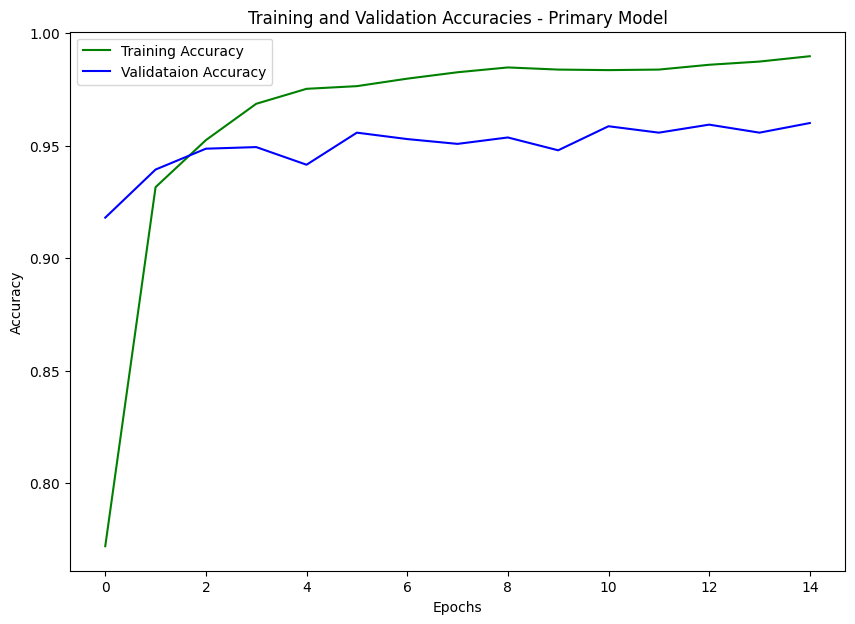

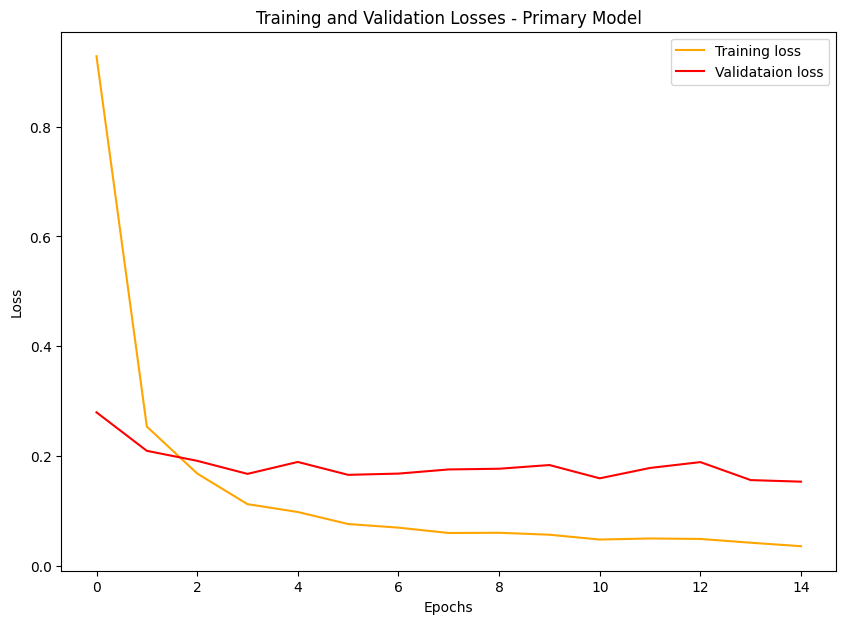

In [27]:
# Learning_parameters.
LR = 0.001
EPOCHS = 15 #12 pretty optimized
model = effnetb2
optimizer = optim.Adam(effnetb2.parameters(), lr=LR) # Optimizer.
criterion = nn.CrossEntropyLoss() # Loss function.

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} / {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(effnetb2, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(effnetb2, val_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, Training Accuracy: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, Validation Accuracy: {valid_epoch_acc:.3f}")
    time.sleep(5)

save_model(EPOCHS, effnetb2, optimizer, criterion, LR)

save_plots(train_acc, valid_acc, train_loss, valid_loss, EPOCHS, LR)

In [28]:
#Test Script
PATH = "MLRSNet Dataset\\Final_outputs\\Perfect Model w AMF\\model_pretrained_epochs15_lr0.001_AMF.pth" #TODO Model Path change before testing

model_test = torchvision.models.efficientnet_b2(weights=None)
for params in model_test.parameters():
        params.requires_grad = False
model_test.trainable = False
model_test.classifier[1] = nn.Linear(in_features=1408, out_features=NUM_CLASSES) ##########################AP1408/1280############################
checkpoint = torch.load(PATH)
model_test.load_state_dict(checkpoint['model_state_dict'])
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

optimizer_test = optim.Adam(model.parameters(), lr=LR) # Optimizer.
criterion_test = nn.CrossEntropyLoss() # Loss function.

model_test.eval()
print('Testing...')
test_running_loss = 0.0
test_running_correct = 0
counter_test = 0
with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
                counter_test += 1

                image, labels = data
                optimizer_test.zero_grad()
                outputs = model_test(image) # Forward pass.
                loss = criterion_test(outputs, labels) # Calculate the loss.
                test_running_loss += loss.item()
                _, preds = torch.max(outputs.data, 1) # Calculate the accuracy.
                test_running_correct += (preds == labels).sum().item()
# Loss and accuracy for the complete epoch.
epoch_loss = test_running_loss / counter_test
epoch_acc = test_running_correct / len(test_loader.dataset)
print(epoch_loss, epoch_acc)

Testing...


100%|██████████| 57/57 [00:38<00:00,  1.49it/s]

0.13732519968445495 0.9580071174377224
